## Import various libraries

In [43]:
import sys
import os
sys.path.append("../")

import numpy as np
import sys
import pandas as pd
import xarray as xr
import tensorflow as tf
from tensorflow import keras

import test_tools
from include.loss import pixel_weighted_cross_entropy

path_all_weights = "../weights"

## Dataset and weights choice
* #### Dataset = images of the hotspot you wish to segment to obtain the plumes (choice of evaluation hotspot)
* #### Weights = weight of the selected trained CNN (choice of training hotspots)

In [44]:
dataset = "seg_berlin"
weights = "seg_all_hotspots"

#### Get dataset, weights, and make predictions to get cnn_wbce

In [45]:
scaler = test_tools.get_scaler(os.path.join(path_all_weights, weights))
data = test_tools.get_data(os.path.join(path_all_weights, dataset), scaler, mode="test")
model = test_tools.get_model(os.path.join(path_all_weights, weights))
name_dataset = data.config.get("data.directory.name")
x_test = tf.convert_to_tensor(data.x.test, np.float32)
pred_test = tf.convert_to_tensor(model.predict(x_test), np.float32)
y_test = tf.convert_to_tensor(data.y.test, np.float32)
data.y.get_plume(xr.open_dataset(data.path_dataset), data.eval_shuffler)
ds_test = xr.open_dataset(data.path_dataset)

cnn_wbce = test_tools.get_wbce(y_test, pred_test)
print("mean wbce:", np.mean(cnn_wbce))
print("median wbce:", np.median(cnn_wbce))

data.x.test.shape (1152, 160, 160, 1)
data.y.test.shape (1152, 160, 160, 1)


/cerea_raid/users/dumontj/usr/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/keras/layers/core/lambda_layer.py:303: UserWarning: models.Unet_backboned is not loaded, but a Lambda layer uses it. It may cause errors.
  function = cls._parse_function_from_config(config, custom_objects,


mean wbce: 0.22615081
median wbce: 0.17501068


#### Get neutral baseline/reference wbce to compute cnn_nwbce and produce some statistics

In [46]:
neutral_wbce = test_tools.get_neutral_baseline_wbce(y_test)

In [47]:
cnn_nwbce = (cnn_wbce / neutral_wbce)
df = pd.DataFrame(cnn_nwbce)
df.describe(percentiles = np.arange(0.125, 1, 0.125))

,0
count,1152.000000
mean,0.458165
std,0.306745
min,0.059196
12.5%,0.160819
25%,0.220583
37.5%,0.289619
50%,0.364667
62.5%,0.477905
75%,0.648422


## Plot examples of segmentations
* #### First draw four indices
* #### For example, here: one in each quartile

In [48]:
first_quartile = [np.percentile(cnn_nwbce, 0),np.percentile(cnn_nwbce, 25)]
[idx0, ds_idx0] = test_tools.draw_idx(cnn_nwbce, ds_test, interval=first_quartile)

nwbce: 0.17737338
idx 329
origin: smart_pBer_nBBer
time: 2015-04-05T17:00:00.000000000
emiss: [22.15086 22.53919 21.75386 20.65153 19.57935 19.53517]


In [49]:
second_quartile = [np.percentile(cnn_nwbce, 25),np.percentile(cnn_nwbce, 50)]
[idx1, ds_idx1] = test_tools.draw_idx(cnn_nwbce, ds_test, interval=second_quartile)

nwbce: 0.25998136
idx 708
origin: smart_pBer_nBBer
time: 2015-08-05T12:00:00.000000000
emiss: [14.27308 14.56812 14.23299 14.07671 14.18506 14.17169]


In [50]:
third_quartile = [np.percentile(cnn_nwbce, 50),np.percentile(cnn_nwbce, 75)]
[idx2, ds_idx2] = test_tools.draw_idx(cnn_nwbce, ds_test, interval=third_quartile)

nwbce: 0.57676023
idx 906
origin: smart_pBer_nBBer
time: 2015-10-05T18:00:00.000000000
emiss: [18.11315 19.95726 21.04821 21.64245 20.97172 19.69296]


In [51]:
fourth_quartile = [np.percentile(cnn_nwbce, 75),np.percentile(cnn_nwbce, 100)]
[idx3, ds_idx3] = test_tools.draw_idx(cnn_nwbce, ds_test, interval=fourth_quartile)

nwbce: 0.68554413
idx 678
origin: smart_pBer_nBBer
time: 2015-08-04T06:00:00.000000000
emiss: [14.43132  13.47072   9.74944   6.895337  6.397456  6.239148]


#### Plot chosen examples

<Figure size 1800x1200 with 0 Axes>

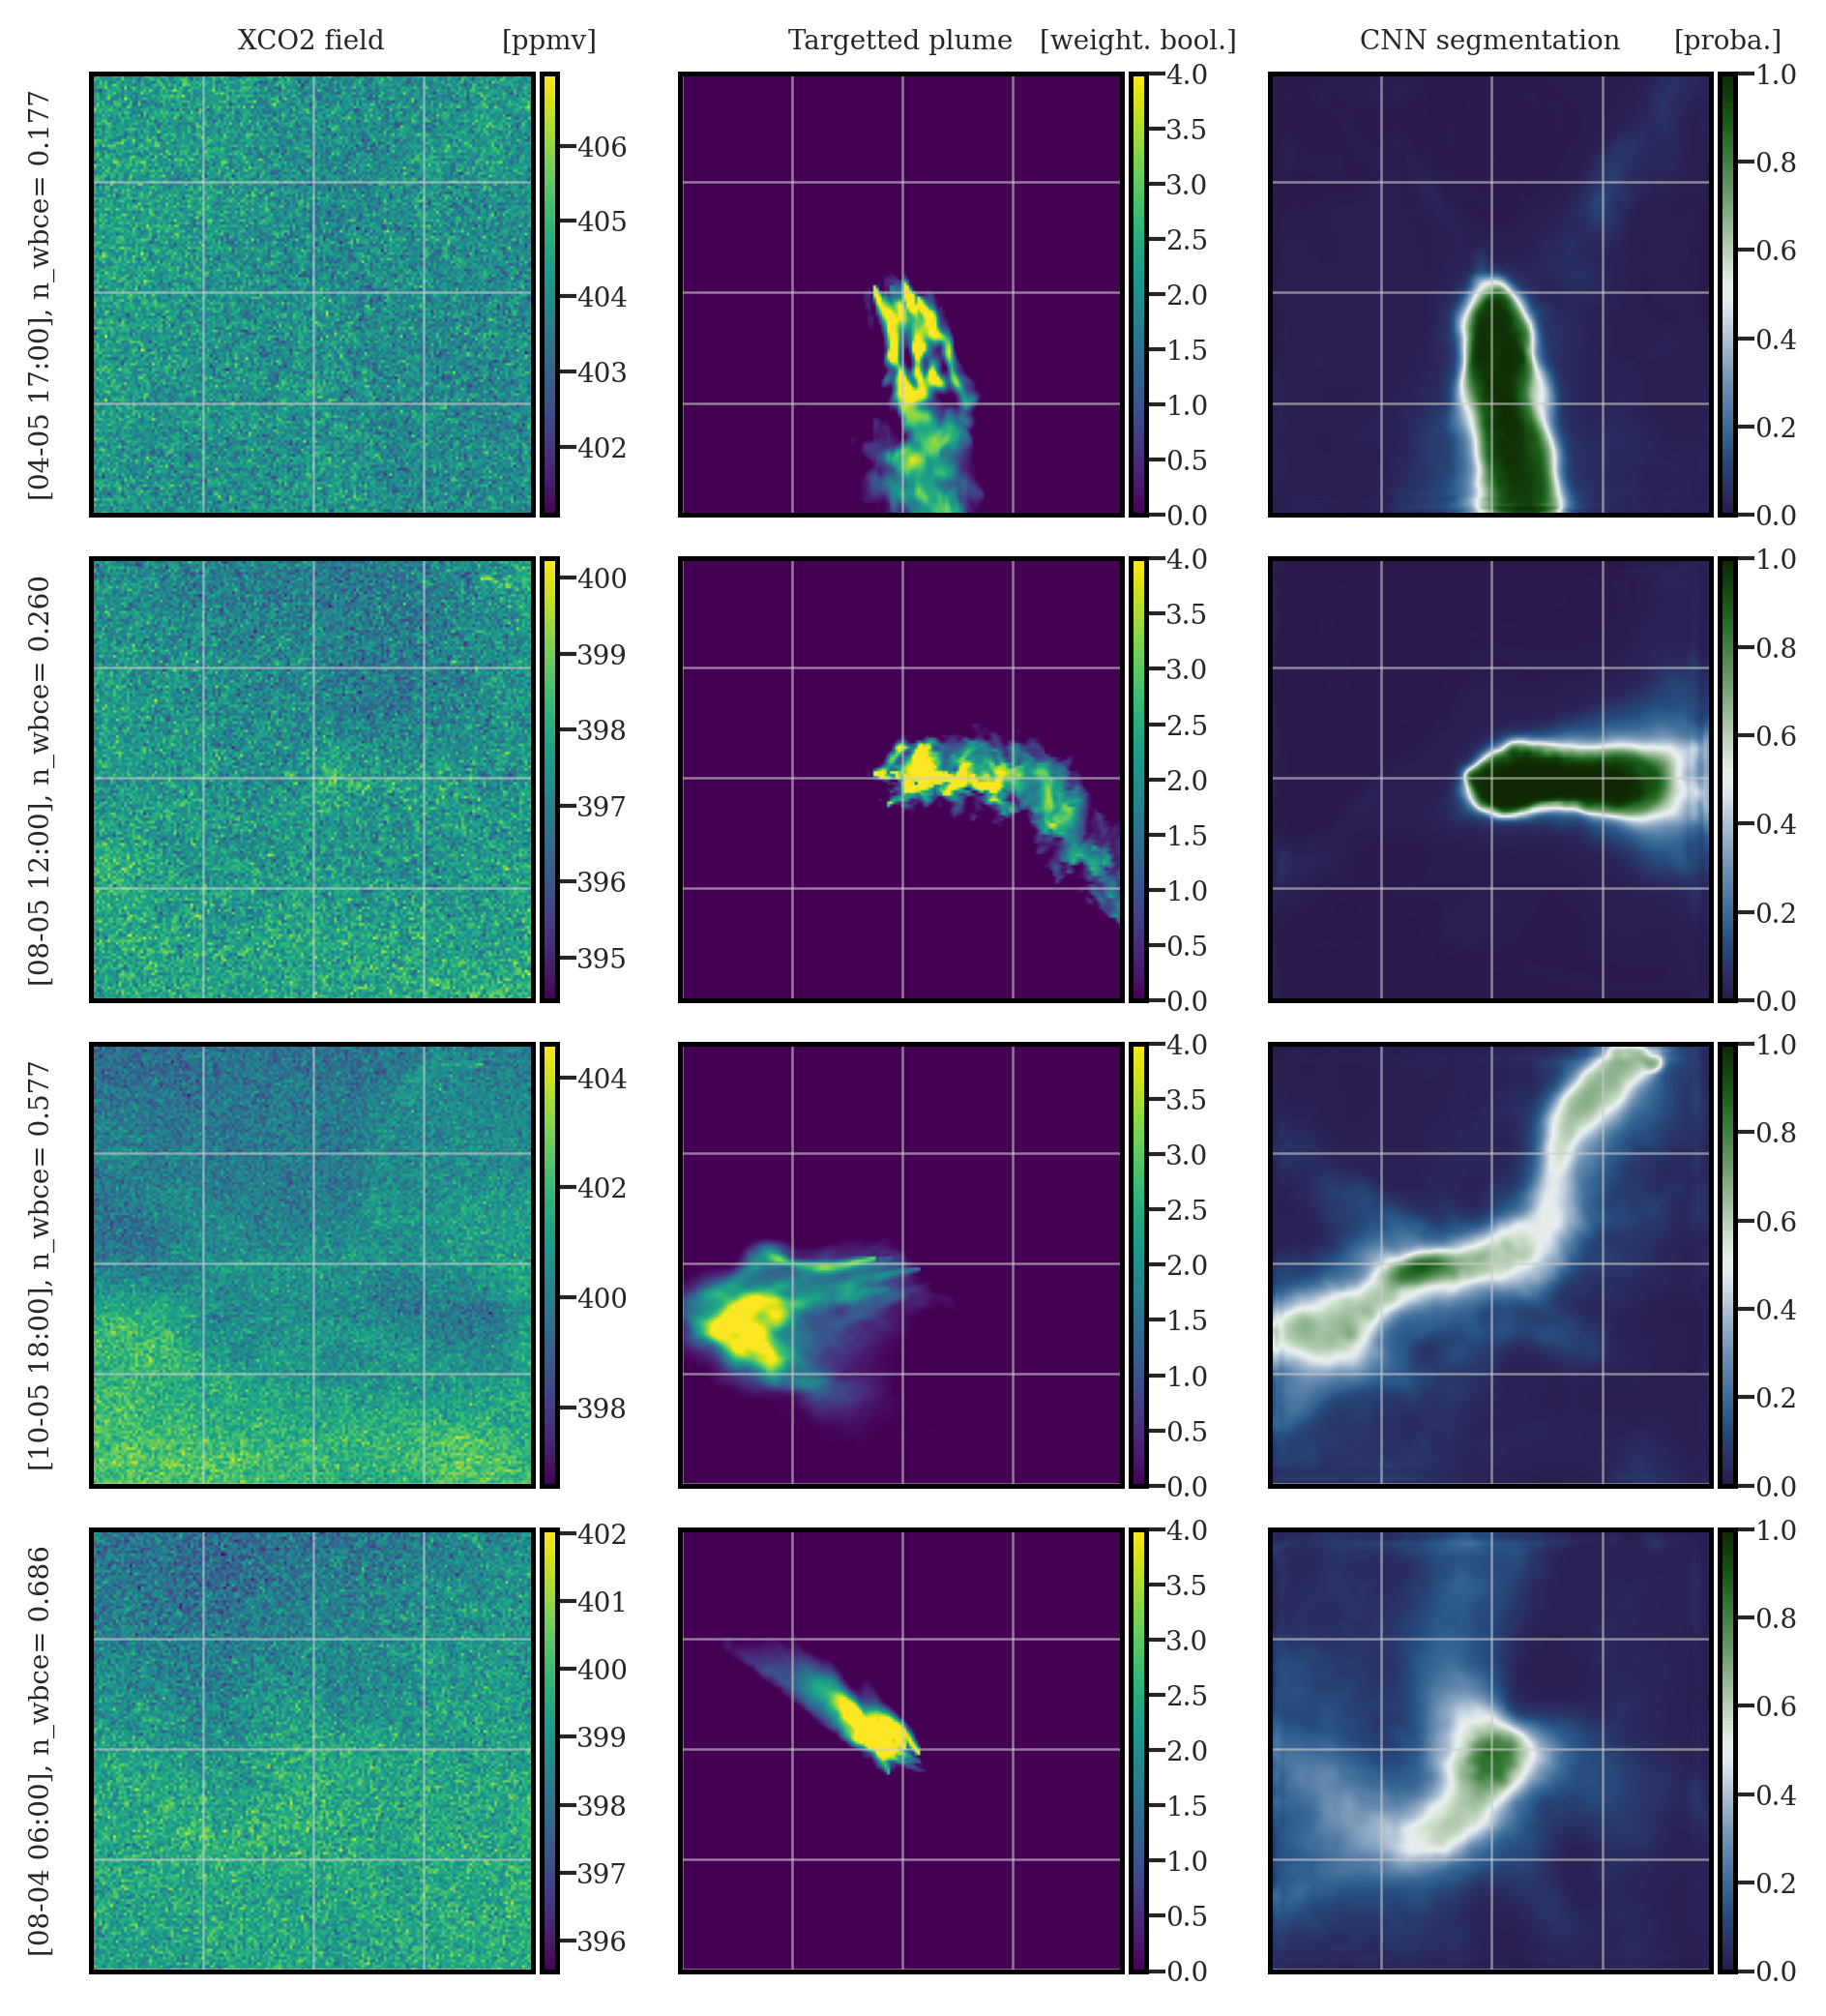

In [52]:
list_idx = [idx0, idx1, idx2, idx3]
list_ds_idx = [ds_idx0, ds_idx1, ds_idx2, ds_idx3]
test_tools.plot_examples(data, cnn_nwbce, scaler, model, list_idx, list_ds_idx)